DENSENET COMPLET - AVEC POIDS LOCAUX
✓ Poids disponibles: True

ÉTAPE 1: PRÉPARATION DES DONNÉES
✓ Chargement des datasets existants...
  Train: 14700, Val: 3150, Test: 3150

ÉTAPE 2: CRÉATION DES GÉNÉRATEURS
Found 14700 validated image filenames belonging to 3 classes.
Found 3150 validated image filenames belonging to 3 classes.
Found 3150 validated image filenames belonging to 3 classes.
✓ Générateurs créés avec 3 classes

ÉTAPE 3: PRÉPARATION DU MODÈLE
ℹ️ Création d'un nouveau modèle avec poids locaux...
Construction du modèle DenseNet201 avec poids locaux...
✓ Chargement des poids depuis: /kaggle/input/modeldense/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5
✓ Poids locaux chargés avec succès!

✓ Modèle créé avec succès
  Couches totales: 9
  Couches gelées: 708
  Paramètres totaux: 18,848,579
✓ Démarrage depuis le début
✓ Phase initiale (couches de base gelées)
✓ Learning rate: 0.0001
✓ Gradient clipping: 1.0

ÉTAPE 4: ENTRAÎNEMENT

ENTRAÎNEMENT - EPOCH 0 À 100
Steps/epo

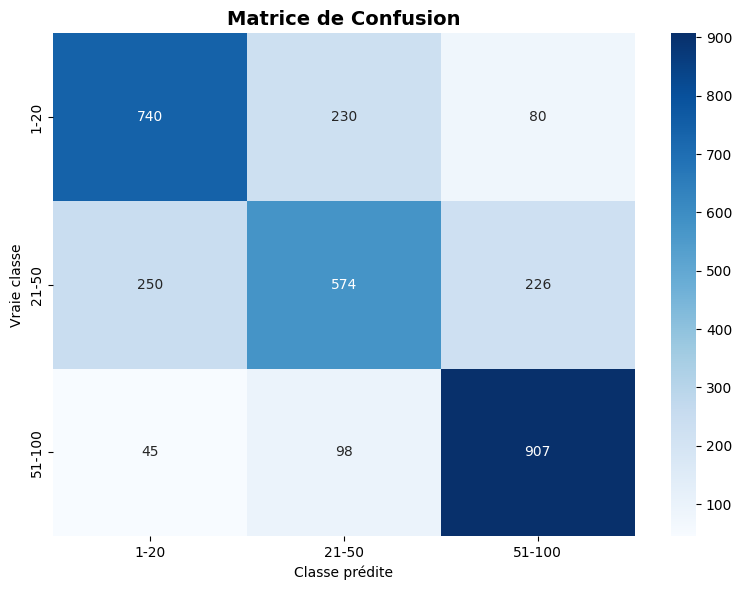


ÉTAPE 6: VISUALISATION


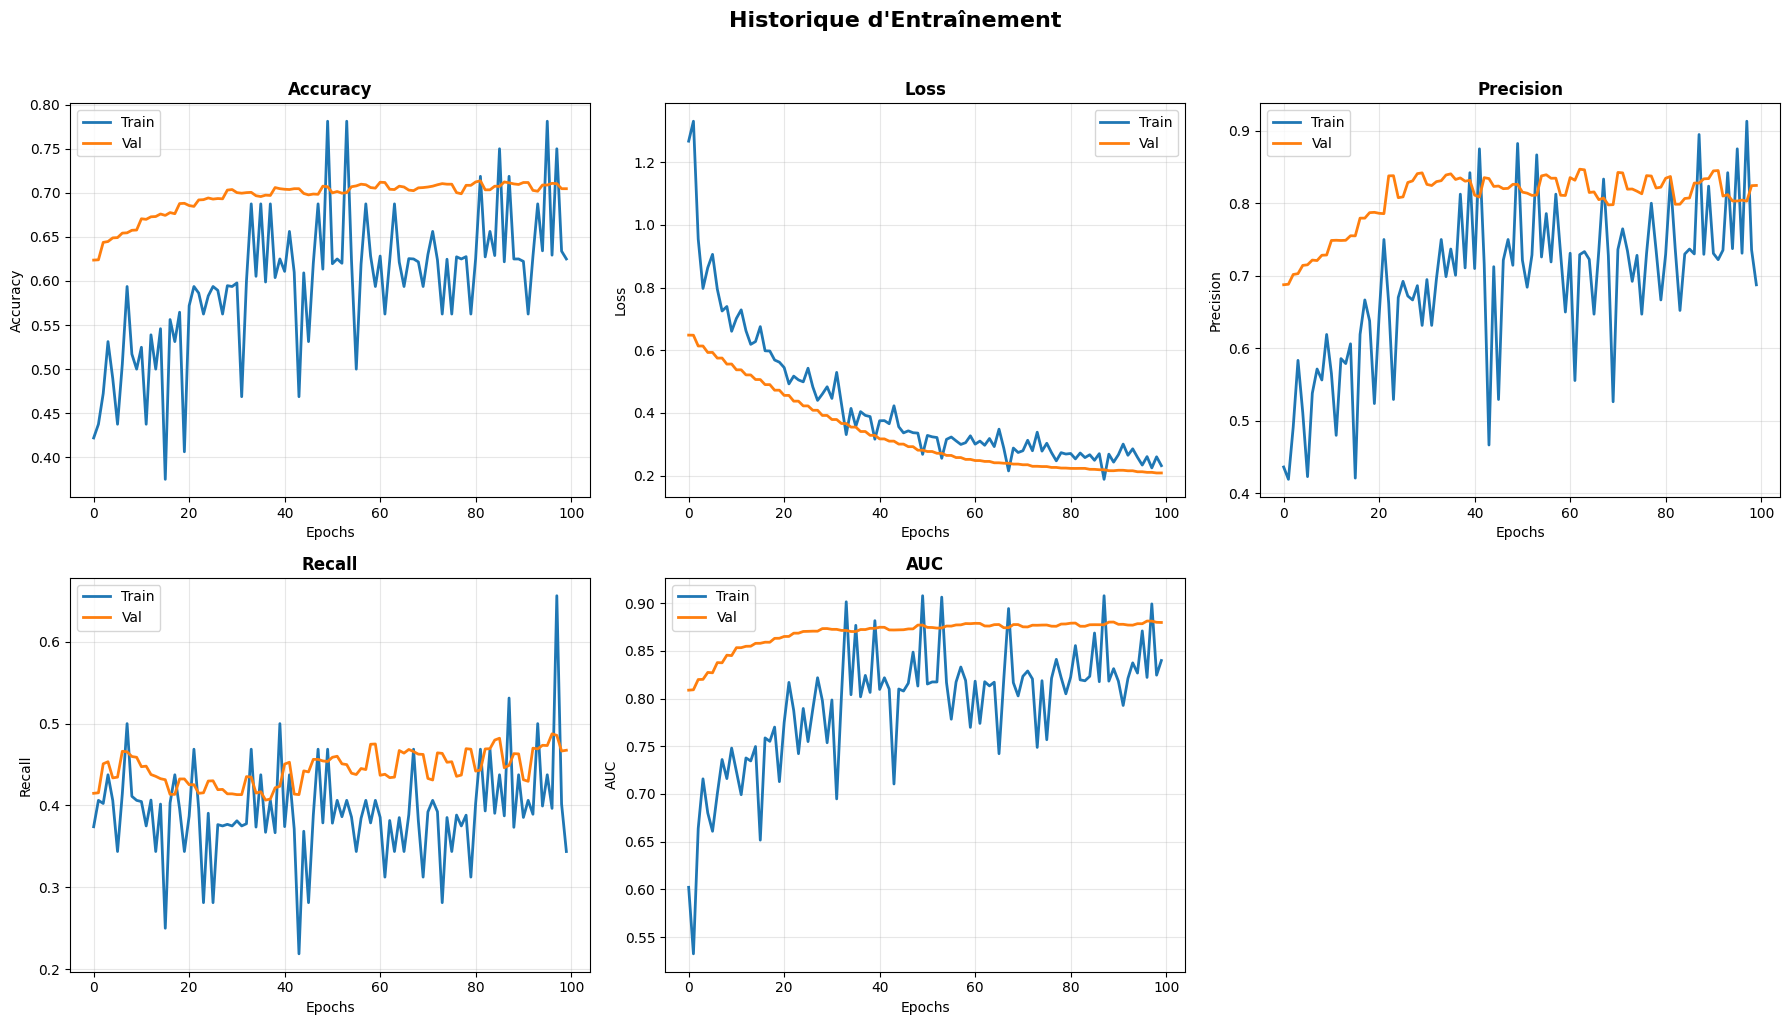


ÉTAPE 7: SAUVEGARDE FINALE
✓ Configuration sauvegardée

RÉSUMÉ DES FICHIERS GÉNÉRÉS:

Modèles:
  ✓ checkpoint_epoch_090.keras (78.3 MB)
  ✓ checkpoint_epoch_095.keras (78.3 MB)
  ✓ checkpoint_epoch_100.keras (78.3 MB)
  ✓ checkpoint_epoch_045.keras (78.3 MB)
  ✓ checkpoint_epoch_065.keras (78.3 MB)
  ✓ checkpoint_epoch_040.keras (78.3 MB)
  ✓ checkpoint_epoch_035.keras (78.3 MB)
  ✓ checkpoint_epoch_015.keras (78.3 MB)
  ✓ checkpoint_epoch_080.keras (78.3 MB)
  ✓ checkpoint_epoch_025.keras (78.3 MB)
  ✓ checkpoint_epoch_060.keras (78.3 MB)
  ✓ checkpoint_epoch_050.keras (78.3 MB)
  ✓ current_model.keras (78.3 MB)
  ✓ checkpoint_epoch_020.keras (78.3 MB)
  ✓ checkpoint_epoch_075.keras (78.3 MB)
  ✓ final_model.keras (78.3 MB)
  ✓ best_model.keras (78.3 MB)
  ✓ checkpoint_epoch_030.keras (78.3 MB)
  ✓ best_accuracy_model.keras (78.3 MB)
  ✓ checkpoint_epoch_010.keras (78.3 MB)
  ✓ checkpoint_epoch_085.keras (78.3 MB)
  ✓ checkpoint_epoch_070.keras (78.3 MB)
  ✓ checkpoint_epoch_055.kera

In [5]:
"""DENSENET AGE CLASSIFIER - AVEC POIDS LOCAUX"""
# ============================================================================
# CONFIGURATION COMPLÈTE
# ============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau, Callback
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CONFIGURATION GÉNÉRALE
# ============================================================================
BASE_PATH = '/kaggle/input/datavgg16/images_organisees'
WORK_DIR = '/kaggle/working/densenet_complete'  # UN seul dossier pour tout
WEIGHTS_PATH = '/kaggle/input/modeldense/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
TOTAL_EPOCHS = 100  # Total souhaité
SEED = 42

# Fixer les seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

os.makedirs(WORK_DIR, exist_ok=True)

print("=" * 80)
print("DENSENET COMPLET - AVEC POIDS LOCAUX")
print("=" * 80)
print(f"✓ Poids disponibles: {os.path.exists(WEIGHTS_PATH)}")

# ============================================================================
# 2. FOCAL LOSS (STABLE)
# ============================================================================
class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.75, name='focal_loss'):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
        
    def call(self, y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = self.alpha * tf.pow(1 - y_pred, self.gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    
    def get_config(self):
        return {'gamma': self.gamma, 'alpha': self.alpha}

# ============================================================================
# 3. CALLBACK PERSONNALISÉ POUR CHECKPOINT PÉRIODIQUE
# ============================================================================
class PeriodicCheckpoint(Callback):
    """Callback personnalisé pour sauvegarder toutes les N epochs"""
    def __init__(self, filepath, save_freq=10):
        super().__init__()
        self.filepath = filepath
        self.save_freq = save_freq
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.filepath.format(epoch=epoch+1)
            self.model.save(filepath)
            print(f"\n✓ Checkpoint sauvegardé: {filepath}")

# ============================================================================
# 4. FONCTION: CHARGER OU CRÉER LES DONNÉES
# ============================================================================
def load_or_create_datasets():
    """Charge les données existantes ou les crée"""
    
    data_files = {
        'train': os.path.join(WORK_DIR, 'train_dataset.csv'),
        'val': os.path.join(WORK_DIR, 'val_dataset.csv'),
        'test': os.path.join(WORK_DIR, 'test_dataset.csv'),
        'class_indices': os.path.join(WORK_DIR, 'class_indices.csv')
    }
    
    # Vérifier si les données existent déjà
    all_exist = all(os.path.exists(f) for f in data_files.values())
    
    if all_exist:
        print("✓ Chargement des datasets existants...")
        train_df = pd.read_csv(data_files['train'])
        val_df = pd.read_csv(data_files['val'])
        test_df = pd.read_csv(data_files['test'])
        class_indices_df = pd.read_csv(data_files['class_indices'])
        
        # Convertir class_indices en dict
        class_indices = {}
        for _, row in class_indices_df.iterrows():
            class_indices[row['class_name']] = row['class_index']
        
        print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
        
        # Récupérer les noms des classes
        class_names = sorted(list(class_indices.keys()))
        
        return train_df, val_df, test_df, class_names, class_indices
    
    else:
        print("ℹ️ Création des datasets...")
        return create_datasets_from_scratch()

def create_datasets_from_scratch():
    """Crée les datasets depuis le début"""
    print("=== ANALYSE DES DONNÉES ORIGINALES ===")
    
    image_paths = []
    labels = []
    class_names = []
    
    for class_dir in os.listdir(BASE_PATH):
        class_path = os.path.join(BASE_PATH, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for img_file in images:
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(class_dir)
                class_names.append(class_dir)
            print(f"  {class_dir}: {len(images)} images")
    
    class_names = sorted(list(set(class_names)))
    class_counts = Counter(labels)
    
    print(f"\nClasses: {class_names}")
    print(f"Total: {len(image_paths)} images")
    
    # Équilibrage
    print("\n=== ÉQUILIBRAGE ===")
    target_count = 7000  # Cible pour chaque classe
    
    class_paths = {}
    for class_name in class_names:
        class_dir = os.path.join(BASE_PATH, class_name)
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_paths[class_name] = images
    
    balanced_paths = {}
    for class_name in class_names:
        paths = class_paths[class_name]
        if len(paths) > target_count:
            selected = random.sample(paths, target_count)
        else:
            needed = target_count - len(paths)
            extra = random.choices(paths, k=needed)
            selected = paths + extra
        balanced_paths[class_name] = selected
        print(f"  {class_name}: {len(paths)} → {len(selected)}")
    
    # Division 70/15/15
    print("\n=== DIVISION TRAIN/VAL/TEST ===")
    train_data, val_data, test_data = [], [], []
    
    for class_name in class_names:
        paths = balanced_paths[class_name]
        labels_list = [class_name] * len(paths)
        
        train_paths, temp_paths, train_labels, temp_labels = train_test_split(
            paths, labels_list, test_size=0.3, random_state=SEED, stratify=labels_list
        )
        
        val_paths, test_paths, val_labels, test_labels = train_test_split(
            temp_paths, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
        )
        
        train_data.extend(zip(train_paths, train_labels))
        val_data.extend(zip(val_paths, val_labels))
        test_data.extend(zip(test_paths, test_labels))
    
    # Créer DataFrames
    train_df = pd.DataFrame(train_data, columns=['filename', 'class'])
    val_df = pd.DataFrame(val_data, columns=['filename', 'class'])
    test_df = pd.DataFrame(test_data, columns=['filename', 'class'])
    
    # Sauvegarder
    train_df.to_csv(os.path.join(WORK_DIR, 'train_dataset.csv'), index=False)
    val_df.to_csv(os.path.join(WORK_DIR, 'val_dataset.csv'), index=False)
    test_df.to_csv(os.path.join(WORK_DIR, 'test_dataset.csv'), index=False)
    
    # Sauvegarder class indices
    class_indices = {name: idx for idx, name in enumerate(class_names)}
    class_indices_df = pd.DataFrame(list(class_indices.items()), 
                                   columns=['class_name', 'class_index'])
    class_indices_df.to_csv(os.path.join(WORK_DIR, 'class_indices.csv'), index=False)
    
    print(f"\n✓ Datasets créés et sauvegardés:")
    print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    return train_df, val_df, test_df, class_names, class_indices

# ============================================================================
# 5. FONCTION: CHARGER OU CRÉER LE MODÈLE AVEC POIDS LOCAUX
# ============================================================================
def load_or_create_model(class_names, resume_training=True):
    """Charge un modèle existant ou en crée un nouveau avec poids locaux"""
    
    model_files = [
        os.path.join(WORK_DIR, 'best_model.keras'),
        os.path.join(WORK_DIR, 'current_model.keras'),
        os.path.join(WORK_DIR, 'final_model.keras')
    ]
    
    # Chercher un modèle existant
    if resume_training:
        for model_file in model_files:
            if os.path.exists(model_file):
                print(f"✓ Chargement du modèle existant: {model_file}")
                try:
                    model = keras.models.load_model(
                        model_file,
                        custom_objects={'FocalLoss': FocalLoss}
                    )
                    
                    # Vérifier si le modèle correspond au nombre de classes
                    output_shape = model.output_shape[-1]
                    if output_shape == len(class_names):
                        print(f"  Modèle compatible: {output_shape} classes")
                        return model, True  # Modèle chargé avec succès
                    else:
                        print(f"  Incompatible: modèle a {output_shape} classes, besoin de {len(class_names)}")
                except Exception as e:
                    print(f"  Erreur chargement: {e}")
    
    # Si pas de modèle ou incompatible, créer un nouveau AVEC POIDS LOCAUX
    print("ℹ️ Création d'un nouveau modèle avec poids locaux...")
    return create_new_model_with_local_weights(len(class_names)), False

def create_new_model_with_local_weights(num_classes):
    """Crée un nouveau modèle DenseNet avec poids locaux"""
    print("Construction du modèle DenseNet201 avec poids locaux...")
    
    # Vérifier si les poids existent
    if os.path.exists(WEIGHTS_PATH):
        print(f"✓ Chargement des poids depuis: {WEIGHTS_PATH}")
        
        # Créer le modèle sans poids d'abord
        base_model = DenseNet201(
            weights=None,  # Pas de téléchargement
            include_top=False,
            input_shape=(224, 224, 3),
            pooling='avg'
        )
        
        # Charger les poids manuellement
        try:
            base_model.load_weights(WEIGHTS_PATH)
            print("✓ Poids locaux chargés avec succès!")
        except Exception as e:
            print(f"✗ Erreur chargement poids: {e}")
            print("ℹ️ Utilisation de l'initialisation aléatoire")
    
    else:
        print("✗ Fichier de poids non trouvé, initialisation aléatoire")
        base_model = DenseNet201(
            weights=None,
            include_top=False,
            input_shape=(224, 224, 3),
            pooling='avg'
        )
    
    # Geler initialement
    base_model.trainable = False
    
    # Architecture
    model = keras.Sequential([
        base_model,
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Afficher le résumé
    print("\n✓ Modèle créé avec succès")
    print(f"  Couches totales: {len(model.layers)}")
    print(f"  Couches gelées: {len([l for l in base_model.layers if not l.trainable])}")
    print(f"  Paramètres totaux: {model.count_params():,}")
    
    return model

# ============================================================================
# 6. FONCTION: PRÉPARER L'ENTRAÎNEMENT
# ============================================================================
def prepare_training(model, is_resume, class_names, train_df, class_weights=None):
    """Prépare l'entraînement ou la reprise"""
    
    # Déterminer l'epoch de départ
    log_file = os.path.join(WORK_DIR, 'training_log.csv')
    if is_resume and os.path.exists(log_file):
        log_df = pd.read_csv(log_file)
        initial_epoch = len(log_df)
        print(f"✓ Reprise depuis l'epoch {initial_epoch}")
        
        # Afficher les meilleures métriques
        if 'val_accuracy' in log_df.columns:
            best_acc = log_df['val_accuracy'].max()
            best_loss = log_df['val_loss'].min()
            print(f"  Meilleure val_accuracy: {best_acc:.4f}")
            print(f"  Meilleure val_loss: {best_loss:.4f}")
    else:
        initial_epoch = 0
        print("✓ Démarrage depuis le début")
    
    # Configurer le modèle selon la phase
    if is_resume and initial_epoch > 20:
        # Phase de fine-tuning (après 20 epochs)
        print("✓ Activation du fine-tuning (toutes les couches dégelées)")
        for layer in model.layers:
            layer.trainable = True
        lr = 1e-5
    else:
        # Phase initiale
        if initial_epoch == 0:
            print("✓ Phase initiale (couches de base gelées)")
            lr = 1e-4
        else:
            print(f"✓ Continuation phase {initial_epoch}")
            lr = 1e-4 * (0.95 ** (initial_epoch // 10))
    
    # Optimizer avec gradient clipping pour stabilité
    optimizer = keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        clipnorm=1.0  # Gradient clipping
    )
    
    # Compiler
    model.compile(
        optimizer=optimizer,
        loss=FocalLoss(gamma=2.0, alpha=0.75),
        metrics=['accuracy', 'precision', 'recall', 'auc']
    )
    
    print(f"✓ Learning rate: {lr}")
    print(f"✓ Gradient clipping: 1.0")
    return model, initial_epoch

# ============================================================================
# 7. FONCTION: CALLBACKS INTELLIGENTS
# ============================================================================
def create_callbacks(initial_epoch):
    """Crée les callbacks avec gestion de la reprise"""
    
    callbacks = [
        # Early stopping avec patience ajustée
        EarlyStopping(
            monitor='val_loss',
            patience=30,  # Augmenté pour la reprise
            restore_best_weights=True,
            verbose=1,
            mode='min',
            min_delta=0.001
        ),
        
        # Meilleur modèle basé sur val_loss
        ModelCheckpoint(
            filepath=os.path.join(WORK_DIR, 'best_model.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
            mode='min'
        ),
        
        # Meilleur modèle basé sur val_accuracy
        ModelCheckpoint(
            filepath=os.path.join(WORK_DIR, 'best_accuracy_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        ),
        
        # Modèle courant (pour reprise)
        ModelCheckpoint(
            filepath=os.path.join(WORK_DIR, 'current_model.keras'),
            save_freq='epoch',
            verbose=0
        ),
        
        # Réduction LR sur plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,  # Réduit pour réagir plus vite
            min_lr=1e-7,
            verbose=1,
            min_delta=0.001
        ),
        
        # CSV Logger (append si reprise)
        CSVLogger(
            os.path.join(WORK_DIR, 'training_log.csv'),
            separator=',',
            append=(initial_epoch > 0)
        ),
        
        # Checkpoint périodique personnalisé (toutes les 5 epochs)
        PeriodicCheckpoint(
            filepath=os.path.join(WORK_DIR, 'checkpoint_epoch_{epoch:03d}.keras'),
            save_freq=5  # Plus fréquent pour plus de sécurité
        )
    ]
    
    return callbacks

# ============================================================================
# 8. FONCTION: ENTRÂINEMENT COMPLET
# ============================================================================
def train_complete(model, train_gen, val_gen, train_df, val_df, initial_epoch, total_epochs=TOTAL_EPOCHS):
    """Exécute l'entraînement complet avec gestion de la reprise"""
    
    steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)
    validation_steps = max(1, len(val_df) // BATCH_SIZE)
    
    print(f"\n{'='*80}")
    print(f"ENTRAÎNEMENT - EPOCH {initial_epoch} À {total_epochs}")
    print(f"{'='*80}")
    print(f"Steps/epoch: Train={steps_per_epoch}, Val={validation_steps}")
    
    # Callbacks
    callbacks = create_callbacks(initial_epoch)
    
    # Calculer les poids de classes pour l'entraînement
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['class']),
        y=train_df['class']
    )
    class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}
    
    # Entraînement
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=total_epochs,
        initial_epoch=initial_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,  # Ajouté pour équilibrage
        verbose=1
    )
    
    return history

# ============================================================================
# 9. FONCTION: ÉVALUATION
# ============================================================================
def evaluate_model(model, test_gen, class_names, class_indices):
    """Évalue le modèle sur le test set"""
    
    print(f"\n{'='*80}")
    print("ÉVALUATION SUR TEST SET")
    print(f"{'='*80}")
    
    # Prédictions
    test_gen.reset()
    y_true = []
    y_pred = []
    y_probs = []
    
    print("Prédiction en cours...")
    for i in range(len(test_gen)):
        x_batch, y_batch = test_gen[i]
        batch_pred = model.predict(x_batch, verbose=0)
        
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))
        y_probs.extend(batch_pred)
        
        if (i + 1) % 10 == 0:
            print(f"  Batch {i+1}/{len(test_gen)}")
    
    # Métriques
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    print(f"\nRÉSULTATS:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    
    # Rapport de classification
    print("\nRapport détaillé:")
    reverse_indices = {v: k for k, v in class_indices.items()}
    print(classification_report(
        y_true, y_pred,
        target_names=[reverse_indices[i] for i in range(len(class_names))],
        digits=4
    ))
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.tight_layout()
    plt.savefig(os.path.join(WORK_DIR, 'confusion_matrix.png'), dpi=300)
    plt.show()
    
    # Sauvegarder les résultats
    results = pd.DataFrame({
        'true': y_true,
        'pred': y_pred,
        'confidence': [max(probs) for probs in y_probs]
    })
    results.to_csv(os.path.join(WORK_DIR, 'predictions.csv'), index=False)
    
    summary = pd.DataFrame({
        'Metric': ['Accuracy', 'F1_Score', 'Balanced_Accuracy'],
        'Value': [accuracy, f1, balanced_acc]
    })
    summary.to_csv(os.path.join(WORK_DIR, 'results_summary.csv'), index=False)
    
    return accuracy, f1, balanced_acc

# ============================================================================
# 10. FONCTION: VISUALISATION
# ============================================================================
def plot_training_history():
    """Visualise l'historique d'entraînement"""
    
    log_file = os.path.join(WORK_DIR, 'training_log.csv')
    if not os.path.exists(log_file):
        print("ℹ️ Pas d'historique disponible")
        return
    
    history_df = pd.read_csv(log_file)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = [
        ('accuracy', 'Accuracy'),
        ('loss', 'Loss'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC')
    ]
    
    for idx, (metric, title) in enumerate(metrics[:5]):
        row, col = idx // 3, idx % 3
        if f'{metric}' in history_df.columns and f'val_{metric}' in history_df.columns:
            axes[row, col].plot(history_df[f'{metric}'], label='Train', linewidth=2)
            axes[row, col].plot(history_df[f'val_{metric}'], label='Val', linewidth=2)
            axes[row, col].set_title(title, fontsize=12, fontweight='bold')
            axes[row, col].set_xlabel('Epochs')
            axes[row, col].set_ylabel(title)
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
    
    # Learning rate si disponible
    if 'lr' in history_df.columns:
        axes[1, 2].plot(history_df['lr'], label='Learning Rate', color='purple', linewidth=2)
        axes[1, 2].set_title('Learning Rate', fontsize=12, fontweight='bold')
        axes[1, 2].set_xlabel('Epochs')
        axes[1, 2].set_ylabel('LR')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].axis('off')
    
    plt.suptitle('Historique d\'Entraînement', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(WORK_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 11. EXÉCUTION PRINCIPALE
# ============================================================================
def main():
    """Fonction principale qui fait tout"""
    
    print("\n" + "="*80)
    print("ÉTAPE 1: PRÉPARATION DES DONNÉES")
    print("="*80)
    
    # Charger ou créer les données
    train_df, val_df, test_df, class_names, class_indices = load_or_create_datasets()
    
    print("\n" + "="*80)
    print("ÉTAPE 2: CRÉATION DES GÉNÉRATEURS")
    print("="*80)
    
    # Créer les générateurs avec augmentation améliorée
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=[0.85, 1.15],
        fill_mode='reflect'
    )
    
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df, x_col='filename', y_col='class',
        target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True, seed=SEED
    )
    
    val_generator = val_test_datagen.flow_from_dataframe(
        dataframe=val_df, x_col='filename', y_col='class',
        target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=test_df, x_col='filename', y_col='class',
        target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    
    print(f"✓ Générateurs créés avec {len(class_names)} classes")
    
    print("\n" + "="*80)
    print("ÉTAPE 3: PRÉPARATION DU MODÈLE")
    print("="*80)
    
    # Charger ou créer le modèle AVEC POIDS LOCAUX
    model, is_resume = load_or_create_model(class_names, resume_training=True)
    
    # Préparer l'entraînement
    model, initial_epoch = prepare_training(
        model, is_resume, class_names, train_df
    )
    
    print("\n" + "="*80)
    print("ÉTAPE 4: ENTRAÎNEMENT")
    print("="*80)
    
    # Entraîner
    history = train_complete(
        model, train_generator, val_generator, train_df, val_df, initial_epoch, TOTAL_EPOCHS
    )
    
    # Sauvegarder le modèle final
    final_path = os.path.join(WORK_DIR, 'final_model.keras')
    model.save(final_path)
    print(f"\n✓ Modèle final sauvegardé: {final_path}")
    
    print("\n" + "="*80)
    print("ÉTAPE 5: ÉVALUATION")
    print("="*80)
    
    # Évaluation
    accuracy, f1, balanced_acc = evaluate_model(
        model, test_generator, class_names, class_indices
    )
    
    print("\n" + "="*80)
    print("ÉTAPE 6: VISUALISATION")
    print("="*80)
    
    # Visualisation
    plot_training_history()
    
    print("\n" + "="*80)
    print("ÉTAPE 7: SAUVEGARDE FINALE")
    print("="*80)
    
    # Sauvegarder la configuration
    config = {
        'base_path': BASE_PATH,
        'work_dir': WORK_DIR,
        'weights_path': WEIGHTS_PATH,
        'image_size': IMAGE_SIZE,
        'batch_size': BATCH_SIZE,
        'total_epochs': TOTAL_EPOCHS,
        'seed': SEED,
        'class_names': ','.join(class_names),
        'final_accuracy': accuracy,
        'final_f1': f1,
        'final_balanced_acc': balanced_acc
    }
    
    config_df = pd.DataFrame(list(config.items()), columns=['Parameter', 'Value'])
    config_df.to_csv(os.path.join(WORK_DIR, 'configuration.csv'), index=False)
    
    print("✓ Configuration sauvegardée")
    
    print("\n" + "="*80)
    print("RÉSUMÉ DES FICHIERS GÉNÉRÉS:")
    print("="*80)
    
    files_by_type = {
        'Modèles': ['.keras'],
        'Données': ['.csv'],
        'Visualisations': ['.png']
    }
    
    for file_type, extensions in files_by_type.items():
        print(f"\n{file_type}:")
        for file in os.listdir(WORK_DIR):
            if any(file.endswith(ext) for ext in extensions):
                size = os.path.getsize(os.path.join(WORK_DIR, file)) / (1024*1024)
                print(f"  ✓ {file} ({size:.1f} MB)")
    
    print("\n" + "="*80)
    print("INSTRUCTIONS POUR REPRENDRE:")
    print("="*80)
    print("1. Pour reprendre l'entraînement, réexécutez simplement ce script")
    print("2. Il détectera automatiquement les fichiers existants")
    print("3. Il reprendra là où il s'est arrêté")
    print("4. Les checkpoints sont sauvegardés toutes les 5 epochs")
    
    print("\n" + "="*80)
    print("✅ TOUT EST TERMINÉ!")
    print("="*80)

# ============================================================================
# 12. EXÉCUTION
# ============================================================================
if __name__ == "__main__":
    # Exécuter le pipeline complet
    main()

In [6]:
# Dans une cellule Kaggle, après entraînement :
import shutil
import os

# 1. Créer une archive ZIP
shutil.make_archive('/kaggle/working/model_package', 'zip', WORK_DIR)

# 2. Télécharger automatiquement
from IPython.display import FileLink
FileLink('/kaggle/working/model_package.zip')

# 3. Ou lister les fichiers pour téléchargement manuel
print("Fichiers à télécharger:")
for file in os.listdir(WORK_DIR):
    size = os.path.getsize(os.path.join(WORK_DIR, file)) / (1024*1024)
    print(f"- {file} ({size:.1f} MB)")

Fichiers à télécharger:
- checkpoint_epoch_090.keras (78.3 MB)
- confusion_matrix.png (0.1 MB)
- checkpoint_epoch_095.keras (78.3 MB)
- checkpoint_epoch_100.keras (78.3 MB)
- train_dataset.csv (1.3 MB)
- test_dataset.csv (0.3 MB)
- class_indices.csv (0.0 MB)
- checkpoint_epoch_045.keras (78.3 MB)
- checkpoint_epoch_065.keras (78.3 MB)
- checkpoint_epoch_040.keras (78.3 MB)
- checkpoint_epoch_035.keras (78.3 MB)
- checkpoint_epoch_015.keras (78.3 MB)
- checkpoint_epoch_080.keras (78.3 MB)
- checkpoint_epoch_025.keras (78.3 MB)
- checkpoint_epoch_060.keras (78.3 MB)
- training_log.csv (0.0 MB)
- checkpoint_epoch_050.keras (78.3 MB)
- training_history.png (0.9 MB)
- results_summary.csv (0.0 MB)
- current_model.keras (78.3 MB)
- checkpoint_epoch_020.keras (78.3 MB)
- checkpoint_epoch_075.keras (78.3 MB)
- predictions.csv (0.0 MB)
- final_model.keras (78.3 MB)
- best_model.keras (78.3 MB)
- checkpoint_epoch_030.keras (78.3 MB)
- best_accuracy_model.keras (78.3 MB)
- checkpoint_epoch_010.ker

In [10]:
"""TEST ULTRA SIMPLE - BYPASS DES ERREURS"""
import numpy as np
from PIL import Image

# 1. Charger sans custom objects (compile=False)
from tensorflow import keras
model = keras.models.load_model(
    '/kaggle/working/densenet_complete/best_model.keras',
    compile=False  # IMPORTANT: bypass la FocalLoss
)

# 2. Préparer l'image
img = Image.open('/kaggle/input/bebetest/bebe.jfif').convert('RGB').resize((224, 224))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 3. Prédire (sans compilation)
predictions = model.predict(img_array, verbose=0)[0]

# 4. Afficher
classes = ['1-20 ans', '21-50 ans', '51-100 ans']
best_idx = np.argmax(predictions)

print("=" * 50)
print(f"RÉSULTAT: {classes[best_idx]}")
print(f"CONFIANCE: {predictions[best_idx]:.1%}")
print("=" * 50)

for cls, prob in zip(classes, predictions):
    print(f"{cls}: {prob:.1%}")

RÉSULTAT: 1-20 ans
CONFIANCE: 64.5%
1-20 ans: 64.5%
21-50 ans: 21.0%
51-100 ans: 14.5%


In [12]:
"""TÉLÉCHARGEMENT DEPUIS KAGGLE"""
import os
import zipfile
import pandas as pd

print("=" * 80)
print("📥 TÉLÉCHARGEMENT DEPUIS KAGGLE")
print("=" * 80)

# ============================================================================
# 1. CRÉER UNE ARCHIVE DE TOUT
# ============================================================================
source_dir = '/kaggle/working/densenet_complete'
output_zip = '/kaggle/working/age_classifier_complete.zip'

if os.path.exists(source_dir):
    print(f"📦 Création de l'archive: {output_zip}")
    
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, source_dir)
                zipf.write(file_path, arcname)
                print(f"  ✓ {arcname}")
    
    zip_size = os.path.getsize(output_zip) / (1024*1024)
    print(f"\n✅ Archive créée: {output_zip}")
    print(f"   Taille: {zip_size:.1f} MB")
else:
    print(f"⚠️ Dossier non trouvé: {source_dir}")
    print("Création d'une archive de /kaggle/working...")
    
    output_zip = '/kaggle/working/kaggle_backup.zip'
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for item in os.listdir('/kaggle/working'):
            item_path = os.path.join('/kaggle/working', item)
            if os.path.isfile(item_path) and not item_path.endswith('.zip'):
                zipf.write(item_path, item)
                print(f"  ✓ {item}")

# ============================================================================
# 2. GÉNÉRER UN INVENTAIRE
# ============================================================================
print("\n📋 INVENTAIRE DES FICHIERS:")

inventory = []
for root, dirs, files in os.walk('/kaggle/working'):
    for file in files:
        if not file.endswith('.zip'):  # Exclure les archives
            file_path = os.path.join(root, file)
            size_mb = os.path.getsize(file_path) / (1024*1024)
            inventory.append({
                'File': os.path.relpath(file_path, '/kaggle/working'),
                'Size_MB': round(size_mb, 2),
                'Type': 'Model' if file.endswith('.keras') else 
                       'Data' if file.endswith('.csv') else
                       'Image' if file.endswith(('.png', '.jpg')) else
                       'Other'
            })

inventory_df = pd.DataFrame(inventory)
inventory_csv = '/kaggle/working/file_inventory.csv'
inventory_df.to_csv(inventory_csv, index=False)

print(f"✅ Inventaire sauvegardé: {inventory_csv}")
print(f"\n📊 RÉSUMÉ:")
print(f"Total fichiers: {len(inventory)}")
print(f"Total taille: {inventory_df['Size_MB'].sum():.1f} MB")

# ============================================================================
# 3. INSTRUCTIONS POUR TÉLÉCHARGER
# ============================================================================
print("\n" + "=" * 80)
print("📝 INSTRUCTIONS DE TÉLÉCHARGEMENT")
print("=" * 80)

print("""
ÉTAPE 1: DANS KAGGLE NOTEBOOK
─────────────────────────────
1. Allez dans l'onglet 'Data' à droite
2. Naviguez vers '/kaggle/working/'
3. Vous verrez tous vos fichiers

ÉTAPE 2: TÉLÉCHARGEMENT
──────────────────────
MÉTHODE A - Archive complète (recommandée):
• Cochez 'age_classifier_complete.zip'
• Cliquez sur 'Download' (icône ↓)

MÉTHODE B - Fichiers individuels:
• Cochez les fichiers importants:
  1. best_model.keras          (Modèle principal)
  2. class_indices.csv         (Classes)
  3. training_log.csv          (Historique)
  4. training_history.png      (Graphique)

ÉTAPE 3: VÉRIFICATION
────────────────────
• L'inventaire complet: file_inventory.csv
• Taille max par fichier sur Kaggle: ~20GB
• Conservez 7 jours maximum
""")

# ============================================================================
# 4. LIENS DIRECTS (pour copier)
# ============================================================================
print("\n🔗 CHEMINS COMPLETS:")
important_files = [
    ('best_model.keras', 'Modèle principal'),
    ('best_accuracy_model.keras', 'Meilleure accuracy'),
    ('final_model.keras', 'Modèle final'),
    ('class_indices.csv', 'Mapping des classes'),
    ('training_log.csv', 'Historique complet'),
    ('training_history.png', 'Graphiques'),
    ('confusion_matrix.png', 'Matrice confusion'),
]

for filename, description in important_files:
    filepath = f'/kaggle/working/densenet_complete/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / (1024*1024)
        print(f"✓ {description:25s}: {filepath}")
        print(f"  {'':25s}  Taille: {size:.1f} MB")
    else:
        # Chercher ailleurs
        for root, dirs, files in os.walk('/kaggle/working'):
            if filename in files:
                full_path = os.path.join(root, filename)
                size = os.path.getsize(full_path) / (1024*1024)
                print(f"✓ {description:25s}: {full_path}")
                print(f"  {'':25s}  Taille: {size:.1f} MB")
                break

print("\n" + "=" * 80)
print("✅ PRÊT POUR LE TÉLÉCHARGEMENT !")
print("=" * 80)

📥 TÉLÉCHARGEMENT DEPUIS KAGGLE
📦 Création de l'archive: /kaggle/working/age_classifier_complete.zip
  ✓ checkpoint_epoch_090.keras
  ✓ confusion_matrix.png
  ✓ checkpoint_epoch_095.keras
  ✓ checkpoint_epoch_100.keras
  ✓ train_dataset.csv
  ✓ test_dataset.csv
  ✓ class_indices.csv
  ✓ checkpoint_epoch_045.keras
  ✓ checkpoint_epoch_065.keras
  ✓ checkpoint_epoch_040.keras
  ✓ checkpoint_epoch_035.keras
  ✓ checkpoint_epoch_015.keras
  ✓ checkpoint_epoch_080.keras
  ✓ checkpoint_epoch_025.keras
  ✓ checkpoint_epoch_060.keras
  ✓ training_log.csv
  ✓ checkpoint_epoch_050.keras
  ✓ training_history.png
  ✓ results_summary.csv
  ✓ current_model.keras
  ✓ checkpoint_epoch_020.keras
  ✓ checkpoint_epoch_075.keras
  ✓ predictions.csv
  ✓ final_model.keras
  ✓ best_model.keras
  ✓ checkpoint_epoch_030.keras
  ✓ best_accuracy_model.keras
  ✓ checkpoint_epoch_010.keras
  ✓ checkpoint_epoch_085.keras
  ✓ configuration.csv
  ✓ checkpoint_epoch_070.keras
  ✓ checkpoint_epoch_055.keras
  ✓ checkpoi

In [13]:
"""DERNIÈRE VÉRIFICATION AVANT DE PARTIR"""
import os
import datetime

print("=" * 70)
print("🔍 ÉTAT DE VOS FICHIERS - DERNIÈRE VÉRIFICATION")
print("=" * 70)

# Liste complète
all_items = []
for root, dirs, files in os.walk('/kaggle/working'):
    for file in files:
        if file.endswith(('.keras', '.csv', '.png', '.log')):
            path = os.path.join(root, file)
            size_mb = os.path.getsize(path) / (1024*1024)
            all_items.append((file, path, size_mb))

print(f"\n📊 TOTAL: {len(all_items)} fichiers importants")

# Grouper par type
keras_files = [(f,p,s) for f,p,s in all_items if f.endswith('.keras')]
csv_files = [(f,p,s) for f,p,s in all_items if f.endswith('.csv')]

print(f"\n🎯 MODÈLES (.keras): {len(keras_files)}")
for file, path, size in keras_files[:3]:
    print(f"   • {file} ({size:.1f} MB)")
if len(keras_files) > 3:
    print(f"   ... et {len(keras_files)-3} autres")

print(f"\n📄 DONNÉES (.csv): {len(csv_files)}")
for file, path, size in csv_files[:3]:
    print(f"   • {file} ({size:.1f} MB)")

print(f"\n⏰ DATE ACTUELLE: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("📅 DERNIER JOUR POUR TÉLÉCHARGER: +7 jours")

print("\n" + "=" * 70)
print("✅ VOUS POUVEZ QUITTER KAGGLE EN TOUTE SÉCURITÉ")
print("=" * 70)
print("\nVos fichiers seront disponibles pendant 7 jours.")
print("Pour les retrouver: revenez sur ce notebook et cherchez dans /kaggle/working/")

🔍 ÉTAT DE VOS FICHIERS - DERNIÈRE VÉRIFICATION

📊 TOTAL: 35 fichiers importants

🎯 MODÈLES (.keras): 24
   • checkpoint_epoch_090.keras (78.3 MB)
   • checkpoint_epoch_095.keras (78.3 MB)
   • checkpoint_epoch_100.keras (78.3 MB)
   ... et 21 autres

📄 DONNÉES (.csv): 9
   • file_inventory.csv (0.0 MB)
   • train_dataset.csv (1.3 MB)
   • test_dataset.csv (0.3 MB)

⏰ DATE ACTUELLE: 2026-01-03 23:42
📅 DERNIER JOUR POUR TÉLÉCHARGER: +7 jours

✅ VOUS POUVEZ QUITTER KAGGLE EN TOUTE SÉCURITÉ

Vos fichiers seront disponibles pendant 7 jours.
Pour les retrouver: revenez sur ce notebook et cherchez dans /kaggle/working/


In [ ]:
"""VÉRIFICATION DU FICHIER ZIP"""
import os

zip_path = '/kaggle/working/age_classifier_complete.zip'

if os.path.exists(zip_path):
    size_mb = os.path.getsize(zip_path) / (1024*1024)
    size_gb = os.path.getsize(zip_path) / (1024*1024*1024)
    
    print("✅ FICHIER TROUVÉ!")
    print(f"📦 Nom: {os.path.basename(zip_path)}")
    print(f"📊 Taille: {size_mb:.1f} MB ({size_gb:.2f} GB)")
    print(f"📁 Chemin: {zip_path}")
    
    # Vérifier le contenu
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        file_list = zipf.namelist()
        print(f"\n📋 CONTENU: {len(file_list)} fichiers")
        for file in file_list[:10]:  # Montrer les 10 premiers
            print(f"   • {file}")
        if len(file_list) > 10:
            print(f"   ... et {len(file_list)-10} autres")
else:
    print("❌ Fichier ZIP non trouvé!")
    print("\n🔍 Création du fichier ZIP maintenant...")
    
    # Créer le ZIP s'il n'existe pas
    import zipfile
    source_dir = '/kaggle/working/densenet_complete'
    
    if os.path.exists(source_dir):
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            file_count = 0
            for root, dirs, files in os.walk(source_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, source_dir)
                    zipf.write(file_path, arcname)
                    file_count += 1
            
            print(f"✅ ZIP créé avec {file_count} fichiers")
            print(f"📦 Taille: {os.path.getsize(zip_path)/(1024*1024):.1f} MB")
    else:
        print("❌ Dossier source non trouvé non plus!")

In [2]:
import os
for root, dirs, files in os.walk('/kaggle/working'):
    for file in files:
        filepath = os.path.join(root, file)
        size = os.path.getsize(filepath)
        print(f"{filepath} - {size/1024:.2f} KB")

/kaggle/working/.virtual_documents/__notebook_source__.ipynb - 36.75 KB


In [3]:
import os
import datetime

print("🔍 VÉRIFICATION D'URGENCE")
print("=" * 60)
print(f"Date/heure actuelle: {datetime.datetime.now()}")
print("\nContenu de /kaggle/working :")

if os.path.exists('/kaggle/working'):
    items = os.listdir('/kaggle/working')
    if items:
        total_size = 0
        for item in items:
            path = os.path.join('/kaggle/working', item)
            if os.path.isfile(path):
                size_mb = os.path.getsize(path) / (1024*1024)
                total_size += size_mb
                print(f"  ✓ {item} ({size_mb:.1f} MB)")
        print(f"\n📊 TOTAL: {len(items)} fichiers, {total_size:.1f} MB")
    else:
        print("  ⚠️ VIDE - Les fichiers ont été perdus")
else:
    print("  ❌ Le dossier n'existe pas")

🔍 VÉRIFICATION D'URGENCE
Date/heure actuelle: 2026-01-04 14:20:41.979725

Contenu de /kaggle/working :

📊 TOTAL: 1 fichiers, 0.0 MB
